In [1]:
# imports
from tqdm import tqdm # progressbar
import os
import numpy as np
from astropy.stats import mad_std
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# JVDP's weighted PCA library
from wpca import WPCA

In [3]:
# load data and generate a matrix of observations
path = 'D:/McDonaldObs_Feb_2024/Results_19th_Feb/RUN_8/SCENE_0/photometry' # 885 sources
#path = 'D:/McDonaldObs_Feb_2024/Results_16th_Feb/RUN_11/SCENE_0/photometry' # 49 sources


files = [f for d, s, f in os.walk(path)][0]

# order the files
phot_files = []
seq_files = []
sky_files = []
batch_ids = np.arange(0, 1000).astype(str)
for b in batch_ids:
    for f in files:
        if 'photometry' in f and 'batch' + b + '.npy' in f:
            phot_files.append(f)
        elif 'seq' in f and 'batch' + b + '.npy' in f:
            seq_files.append(f)
        elif 'sky' in f and 'batch' + b + '.npy' in f:
            sky_files.append(f)

In [4]:
# load source positions
positions = np.load(os.path.join(path, 'positions.npy'))
bb_pos = np.load(os.path.join(path, 'bb_pos.npy'))
positions.shape, bb_pos.shape

((885, 2), (5, 2))

In [5]:
n = 0 # use as reference for array dimensions
fs = np.load(os.path.join(path, phot_files[n])) # use for shape info
ss = np.load(os.path.join(path, sky_files[n]))
data = np.zeros((len(phot_files), fs.shape[0], fs.shape[1])) # data matrix
t = np.zeros((len(seq_files), fs.shape[0])) # observation sequence numbers (i.e. time)
bkgs = np.zeros((len(sky_files), ss.shape[0], ss.shape[1]))

# staple together the data in files
def batch_files(files, arr):
    for i,file in enumerate(files):
        arr[i] = np.load(os.path.join(path, file))
    return arr

data = batch_files(phot_files, data)
t = batch_files(seq_files, t)
bkgs = batch_files(sky_files, bkgs)

In [6]:
# reshape and change dtype
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2]).astype(np.float32)
bkgs = bkgs.reshape(bkgs.shape[0] * bkgs.shape[1], bkgs.shape[2]).astype(np.float32)
t = t.flatten().astype(np.float32)
data.shape, data.dtype, t.shape, t.dtype, bkgs.shape, bkgs.dtype

((408000, 885),
 dtype('float32'),
 (408000,),
 dtype('float32'),
 (408000, 5),
 dtype('float32'))

In [7]:
# generate observatons matrix (n_samples x n_features)
X = np.copy(data)
X.shape

(408000, 885)

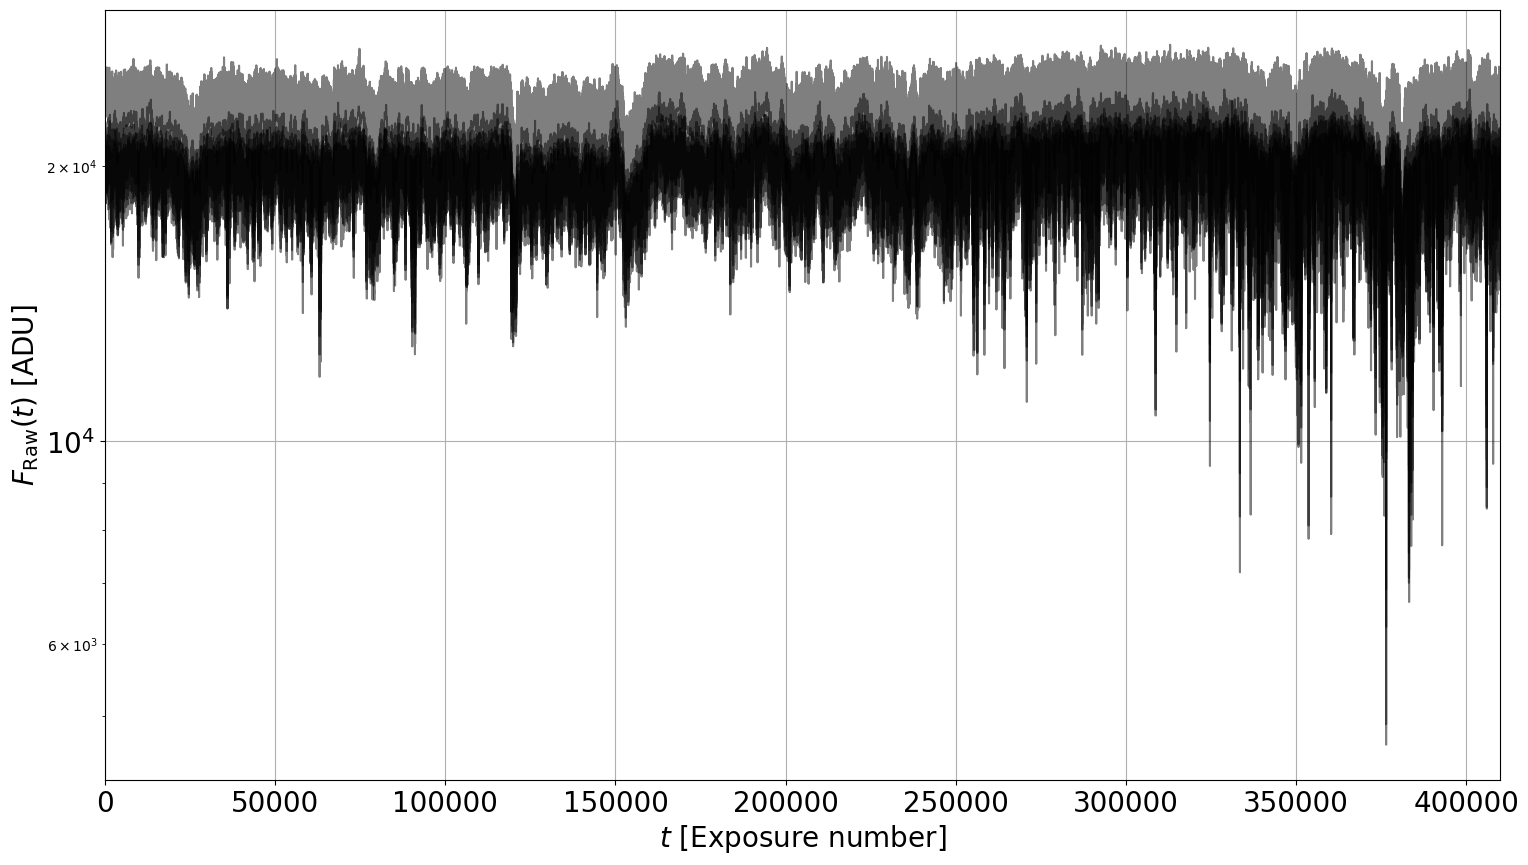

In [8]:
# by-eye check - should see co-trending behaviour
fs = 20
plt.figure(figsize=(18,10))
#stars = [0, 1, 25]
stars = [0, 1, 2, 3, 4, 5]
plt.plot(t, X[:, stars], c='black', alpha=0.5)
plt.ylabel('$F_{\mathrm{Raw}}(t)$ [ADU]', fontsize=fs)
plt.xlabel('$t$ [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
#plt.ylim(1e4, 1e6)
plt.yscale('log')
plt.grid();
#plt.savefig('figures/Raw_timeseries.png', bbox_inches='tight')

In [9]:
# normalise light curves
X_norm = X / np.median(X, axis=0)
X_norm.shape

(408000, 885)

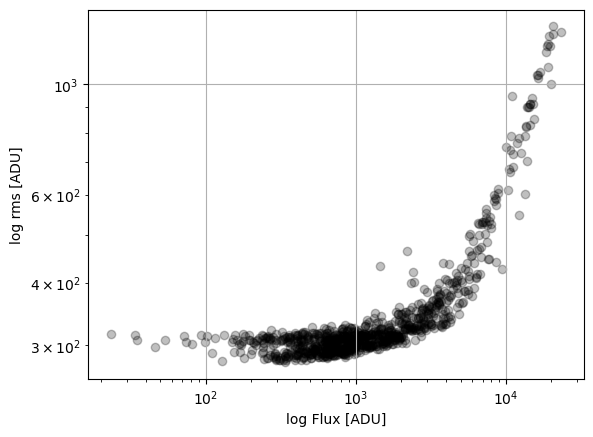

In [10]:
# plot of std vs median flux
plt.scatter(np.median(X, axis=0), np.std(X, axis=0)[:, None], alpha=0.25, c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log Flux [ADU]')
plt.ylabel('log rms [ADU]')
plt.grid();

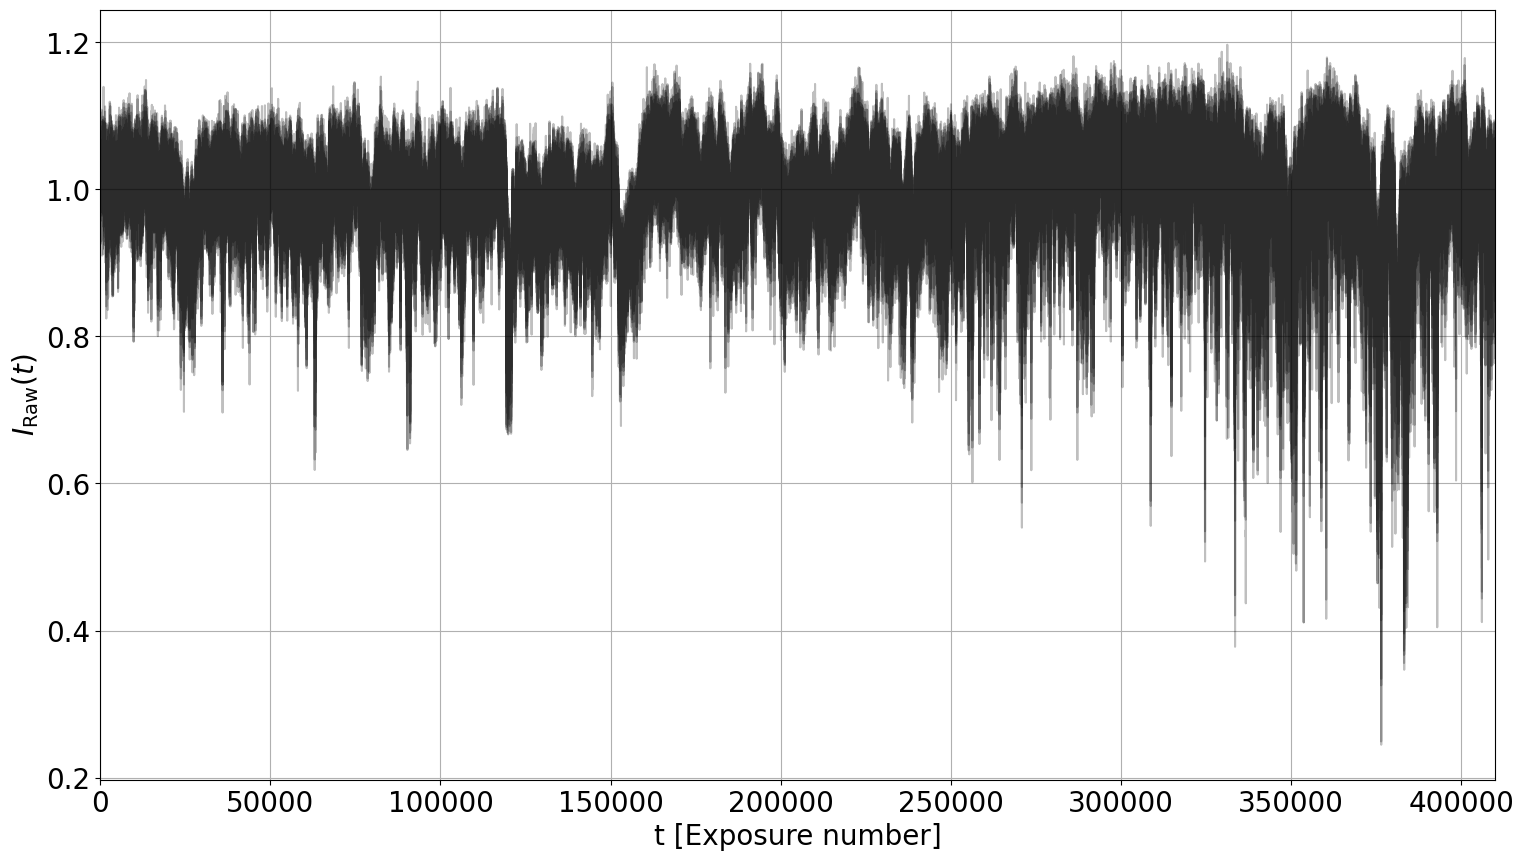

In [11]:
plt.figure(figsize=(18,10))
plt.plot(t, X_norm[:, stars], c='black', alpha=0.25)
plt.ylabel('$I_{\mathrm{Raw}}(t)$', fontsize=fs)
plt.xlabel('t [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
plt.grid()
#plt.savefig('figures/Normalised_timeseries.png', bbox_inches='tight')

In [12]:
# standardise w.r.t STD/var?
# reshape to data matrix is n_samples x n_features
X_norm = X_norm.T
X_norm.shape

(885, 408000)

In [13]:
# for testing purposes / memory allocation issues, slice a test chunk of data
X_norm = X_norm[:, :10000]
X_norm.shape

(885, 10000)

In [14]:
T = X_norm.shape[1]
CHUNK_SIZE = 10000
chunks = np.concatenate((np.arange(0, T, CHUNK_SIZE), np.array([T])))
res_dest = np.ones(X_norm.shape)
for i in range(len(chunks)-1):
    res_dest[:,chunks[i]:chunks[i+1]] = X_norm[:,chunks[i]:chunks[i+1]]
np.all(res_dest == X_norm)

True

In [15]:
# target source to detrend
source = 100

In [16]:
# compare against wav approach
comparison_stars = np.where(np.std(X_norm[:, :], axis=1) < 0.1)[0]
comparison_stars = [comp_star for comp_star in comparison_stars if comp_star != source]
wav = np.average(X_norm[comparison_stars],
                     weights=1/np.var(X_norm[comparison_stars], axis=1), axis=0)
res_wav = X_norm / wav
res_wav.shape

(885, 10000)

In [17]:
# centre
X_norm -= np.median(X_norm, axis=1)[:, None]
#X_norm /= np.std(X_norm, axis=1)[:, None]
X_norm.shape

(885, 10000)

In [18]:
# inject occultation signal into a time series
#source = 10
#X_norm[source][1000:1010] = X_norm[source][1000:1010] - 0.25

In [19]:
# define weight matrix (weight out the target source)
weights = 1/np.var(X_norm, axis=1)
weights = weights[:,None] * np.ones(X_norm.shape)
weights[source] = 1e-6 * np.ones(weights[source].shape) # weight out the target star (0s result in Singular matrix error)
weights[source]

array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06])

In [20]:
# fit and predict via WPCA model
n_component = 8
pca = WPCA(n_components=n_component).fit(X_norm, weights=weights) # fit pca model
Y = pca.fit_reconstruct(X_norm, weights=weights) # make predictions

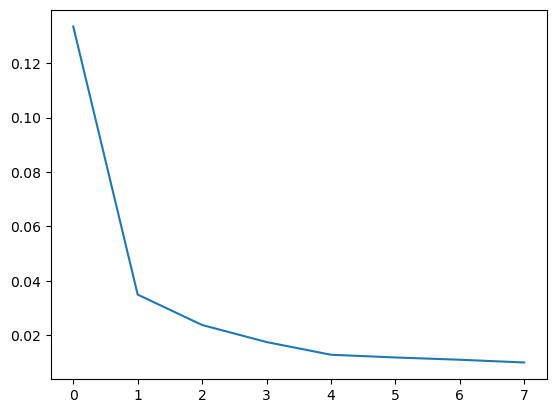

In [21]:
# check explained variance curve
plt.plot(pca.explained_variance_ratio_);

In [22]:
# compute residuals (i.e. "detrended" time series)
res = X_norm - Y

C:\Users\James\AppData\Local\Temp\ipykernel_25820\1754532427.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 15)
C:\Users\James\AppData\Local\Temp\ipykernel_25820\1754532427.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 15)


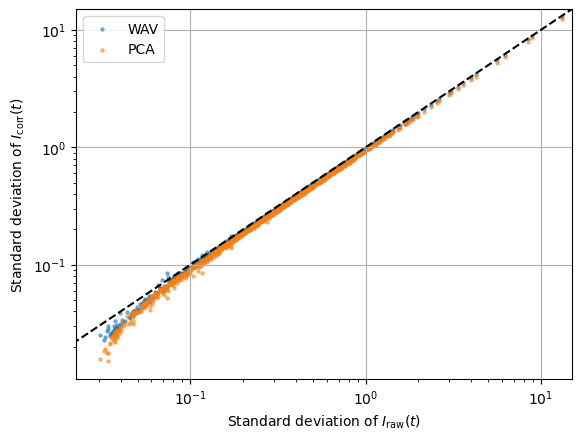

In [23]:
# plot pre correction vs post correction std
plt.scatter(np.std(X_norm, axis=1), np.std(res_wav, axis=1), s=5, c='tab:blue', alpha=0.5, label='WAV')
plt.scatter(np.std(X_norm, axis=1), np.std(res, axis=1), s=5, c='tab:orange', alpha=0.5, label='PCA')
plt.plot(np.arange(0, 20), np.arange(0, 20), linestyle='--', c='k')
plt.xlabel('Standard deviation of $I_{\mathrm{raw}}(t)$')
plt.ylabel('Standard deviation of $I_{\mathrm{corr}}(t)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.legend()
plt.grid();

C:\Users\James\AppData\Local\Temp\ipykernel_25820\860665716.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1)
C:\Users\James\AppData\Local\Temp\ipykernel_25820\860665716.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


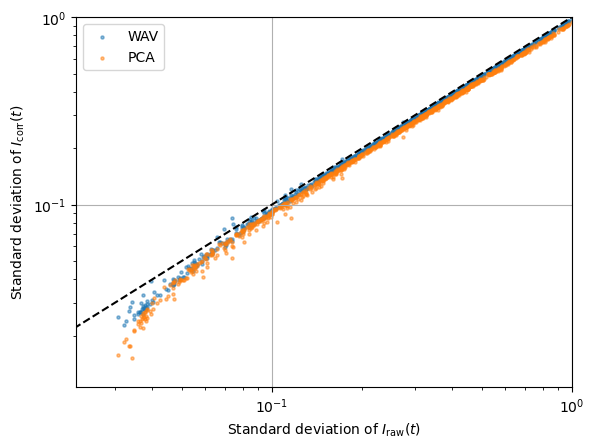

In [24]:
# plot pre correction vs post correction std
plt.scatter(np.std(X_norm, axis=1), np.std(res_wav, axis=1), s=5, c='tab:blue', alpha=0.5, label='WAV')
plt.scatter(np.std(X_norm, axis=1), np.std(res, axis=1), s=5, c='tab:orange', alpha=0.5, label='PCA')
plt.plot(np.arange(0, 20), np.arange(0, 20), linestyle='--', c='k')
plt.xlabel('Standard deviation of $I_{\mathrm{raw}}(t)$')
plt.ylabel('Standard deviation of $I_{\mathrm{corr}}(t)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid();

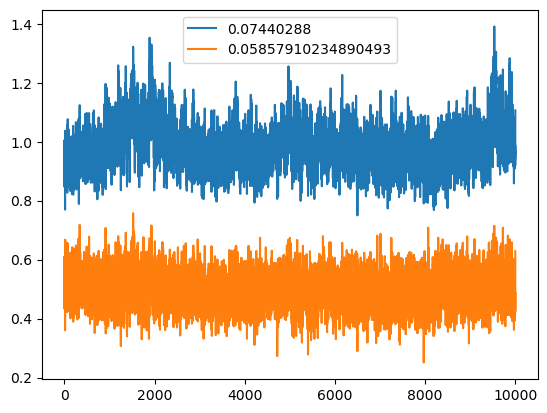

In [25]:
cut = -1
alpha = 1
plt.plot(res_wav[source][:cut], c='tab:blue', alpha=alpha, label=np.std(res_wav[source][:cut]))
plt.plot(res[source][:cut] + 0.5, c='tab:orange', alpha=alpha, label=np.std(res[source][:cut]))
plt.legend();

In [20]:
weights = 1/np.var(X_norm, axis=1)
weights = weights[:,None] * np.ones(X_norm.shape)
n_component = 8
pca = WPCA(n_components=n_component).fit(X_norm, weights=weights) # fit pca model
Y = pca.fit_reconstruct(X_norm, weights=weights) # make predictions

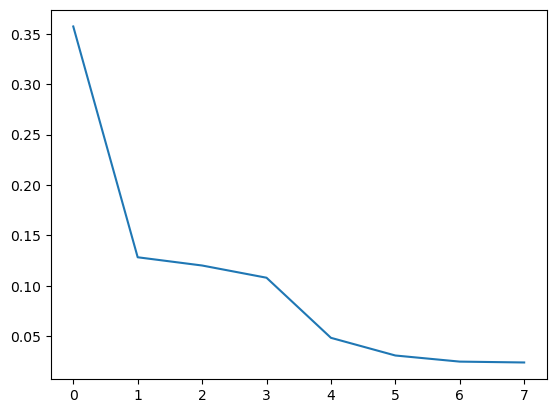

In [21]:
# check explained variance curve
plt.plot(pca.explained_variance_ratio_);

In [22]:
# compute residuals (i.e. "detrended" time series)
res = X_norm - Y

C:\Users\James\AppData\Local\Temp\ipykernel_15992\1754532427.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 15)
C:\Users\James\AppData\Local\Temp\ipykernel_15992\1754532427.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 15)


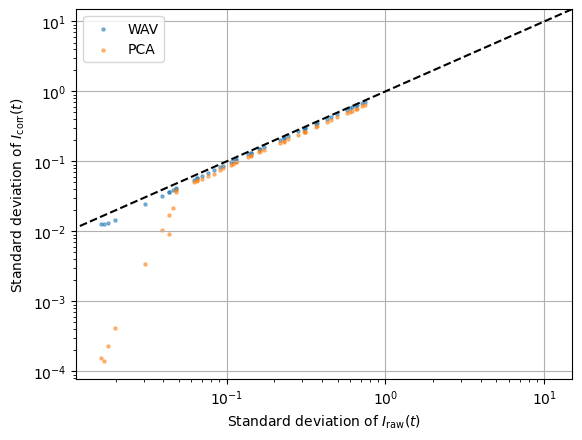

In [23]:
# plot pre correction vs post correction std
plt.scatter(np.std(X_norm, axis=1), np.std(res_wav, axis=1), s=5, c='tab:blue', alpha=0.5, label='WAV')
plt.scatter(np.std(X_norm, axis=1), np.std(res, axis=1), s=5, c='tab:orange', alpha=0.5, label='PCA')
plt.plot(np.arange(0, 20), np.arange(0, 20), linestyle='--', c='k')
plt.xlabel('Standard deviation of $I_{\mathrm{raw}}(t)$')
plt.ylabel('Standard deviation of $I_{\mathrm{corr}}(t)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.legend()
plt.grid();

C:\Users\James\AppData\Local\Temp\ipykernel_15992\860665716.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1)
C:\Users\James\AppData\Local\Temp\ipykernel_15992\860665716.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


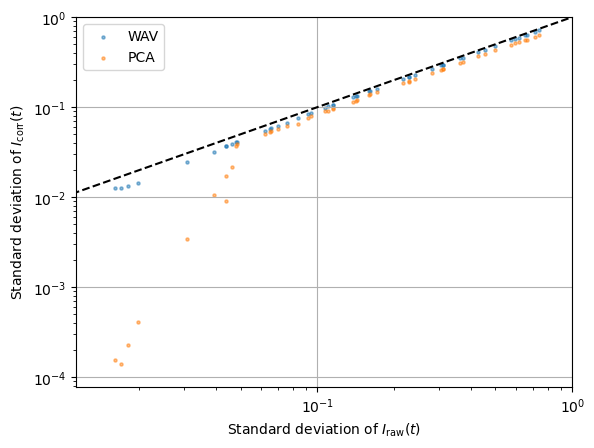

In [24]:
# plot pre correction vs post correction std
plt.scatter(np.std(X_norm, axis=1), np.std(res_wav, axis=1), s=5, c='tab:blue', alpha=0.5, label='WAV')
plt.scatter(np.std(X_norm, axis=1), np.std(res, axis=1), s=5, c='tab:orange', alpha=0.5, label='PCA')
plt.plot(np.arange(0, 20), np.arange(0, 20), linestyle='--', c='k')
plt.xlabel('Standard deviation of $I_{\mathrm{raw}}(t)$')
plt.ylabel('Standard deviation of $I_{\mathrm{corr}}(t)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid();

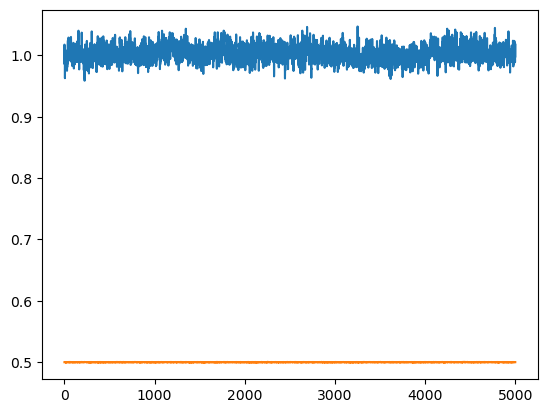

In [25]:
source = 0
cut = -1
alpha = 1
#plt.plot(X_norm[source][:cut] + 1, c='k', alpha=alpha)
plt.plot(res[source][:cut] + 0.5, c='tab:orange', alpha=alpha)

#plt.plot(X_norm[source][:cut] + 0.75 , c='k', alpha=alpha)
plt.plot(res_wav[source][:cut], c='tab:blue', alpha=alpha)

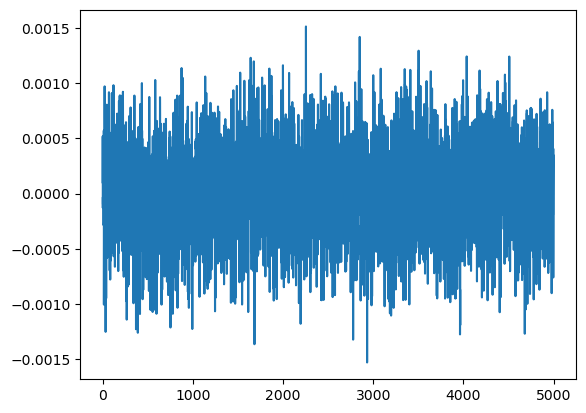

In [26]:
#res += 1
plt.plot(res[3])